In [1]:
from PIL import Image
import os
import cv2

import torch.tensor as tensor
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import random_split as random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import time

In [2]:
torch.cuda.is_available()

True

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
width, height= 224,224
batch_size=32
learning_rate=0.001

In [5]:
train_dir='Training'
test_dir='Testing'

In [6]:
num_classes=len(os.listdir(train_dir))
num_classes

4

In [15]:
# Tensor 변환, 이미지 input size 맞춰주기 등 input data에 대한 전처리
image_transforms={
    'train':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),    
#             transforms.RandomHorizontalFlip(),     
    ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),    
    ])
}


#data 직접 가져와서 transform
data={
    'train':datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'test':datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

In [16]:
train_data_loader=DataLoader(data['train'], batch_size=batch_size, shuffle=True)
test_data_loader=DataLoader(data['test'], batch_size=batch_size, shuffle=False)

In [17]:
# len_train=len(data['train'])
len_train=len(data['train'])
len_test=len(data['test'])
print('length of train_data: ',len(data['train']))
print('length of test_data: ',len(data['test']))

length of train_data:  2871
length of test_data:  394


In [18]:
for dir in ['/glioma_tumor', '/meningioma_tumor', '/no_tumor', '/pituitary_tumor']:
    print(dir , ':', len(os.listdir(train_dir+dir)))

/glioma_tumor : 827
/meningioma_tumor : 822
/no_tumor : 395
/pituitary_tumor : 827


In [19]:
indexes={k:v for k,v in data['train'].class_to_idx.items()}
print(indexes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


0
<class 'numpy.ndarray'>


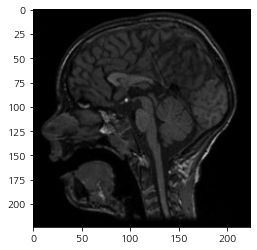

In [20]:
#이미지 보기
for batch_idx, (inputs, targets) in enumerate(train_data_loader):
    if batch_idx==1:
        break
    else:
        print(batch_idx)
        img=inputs[batch_idx].numpy()
        print(type(img))
        plt.imshow(np.transpose(img,(1,2,0)))
        plt.show()

In [21]:
print(img.shape)
print(type(img))
print(np.transpose(img,(1,2,0)).shape)

(3, 224, 224)
<class 'numpy.ndarray'>
(224, 224, 3)


In [22]:
base_model=models.mobilenet_v3_large(pretrained=True)

for param in base_model.parameters():
    param.requires_grad=True
    param.requires_bias=True

n_inputs=base_model.classifier[-1].in_features

# base_model.classifier[-1]=nn.Linear(n_inputs, 4)

base_model.classifier=nn.Sequential(nn.Linear(960, 516),
                                    nn.Dropout(0.5),
                                    nn.Linear(516, 64),
                                    nn.Dropout(0.2),
                                    nn.Linear(64, 32),
                                    nn.Dropout(0.2),
                                    nn.Linear(32, 4)
                            )

base_model=base_model.to(device)

In [23]:
from torchsummary import summary
summary(base_model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
          Identity-9         [-1, 16, 112, 112]               0
 InvertedResidual-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           1,024
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14           [-1, 64,

In [24]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(base_model.parameters(), lr=0.001)

In [25]:
def train(model, loss, optimizer, epochs):
    start=time.time()
    history=[]
    best_acc=0.0
    
    for epoch in range(epochs):
        epoch_start=time.time()
        print('Epoch : {} / {}' .format(epoch+1, epochs))

        model.train()

        train_loss=0.0
        train_acc=0.0

        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)

            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item() * inputs.size(0)

            ret, predictions=torch.max(outputs.data,1)
            correct_counts=predictions.eq(labels.data.view_as(predictions))

            acc=torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc+=acc.item() * inputs.size(0)
            
    
        avg_train_loss=train_loss/len_train
        avg_train_acc=train_acc/len_train
        print('Training : loss - {:.4f}, Accuracy - {:4f}'.format(avg_train_loss, avg_train_acc))
        history.append([avg_train_loss, avg_train_acc])
        
        
    
        
    epoch_end=time.time()
    print("Epoch :{:03d} , Validation: loss - {:.4f}, Accuracy - {:4f}, Time : {:4f}s"\
          .format(epoch+1, avg_train_loss, (avg_train_acc)*100, epoch_end-epoch_start))
    
#     torch.save(model.state_dict(), '/models')
#     torch.save('model_2', '/models')
    
    return model, history


In [26]:
epochs=30
train_model, train_history=train(base_model, criterion, optimizer, epochs)

Epoch : 1 / 30
Training : loss - 0.4042, Accuracy - 0.856496
Epoch : 2 / 30
Training : loss - 0.1799, Accuracy - 0.945315
Epoch : 3 / 30
Training : loss - 0.1114, Accuracy - 0.961338
Epoch : 4 / 30
Training : loss - 0.0994, Accuracy - 0.964821
Epoch : 5 / 30
Training : loss - 0.1458, Accuracy - 0.963776
Epoch : 6 / 30
Training : loss - 0.0563, Accuracy - 0.982584
Epoch : 7 / 30
Training : loss - 0.0278, Accuracy - 0.990247
Epoch : 8 / 30
Training : loss - 0.0752, Accuracy - 0.980146
Epoch : 9 / 30
Training : loss - 0.0631, Accuracy - 0.981540
Epoch : 10 / 30
Training : loss - 0.0524, Accuracy - 0.981191
Epoch : 11 / 30
Training : loss - 0.0447, Accuracy - 0.988506
Epoch : 12 / 30
Training : loss - 0.0325, Accuracy - 0.989899
Epoch : 13 / 30
Training : loss - 0.0210, Accuracy - 0.995124
Epoch : 14 / 30
Training : loss - 0.0152, Accuracy - 0.995820
Epoch : 15 / 30
Training : loss - 0.0125, Accuracy - 0.995124
Epoch : 16 / 30
Training : loss - 0.0115, Accuracy - 0.996169
Epoch : 17 / 30
T

In [27]:
train_model.eval()
correct=0
total=0

with torch.no_grad(): #test니까 gradient update 없음
    for images , labels in test_data_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=train_model(images)
        _, predicted= torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Test Accuracy {} %'.format(round(100*correct/total , 6)))

Test Accuracy 77.411168 %


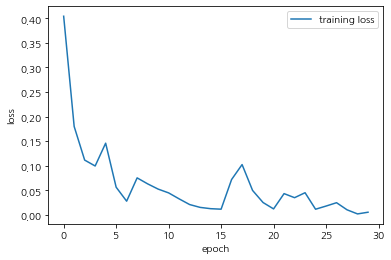

In [28]:
history=np.array(train_history)
plt.plot(history[:,0])
plt.legend(['training loss'])
# plt.xticks([i for i in range(1,epochs+1)])
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('loss.png')
plt.rcParams['axes.unicode_minus'] = False  
plt.show()

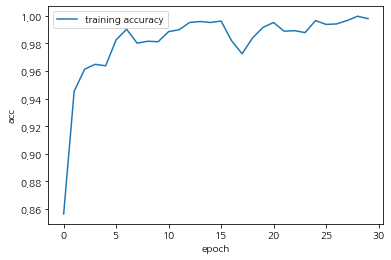

In [29]:
history=np.array(train_history)
plt.plot(history[:,1])
plt.legend(['training accuracy'])
# plt.xticks([i for i in range(1,epochs+1)])
plt.xlabel('epoch')
plt.ylabel('acc')
# plt.savefig('loss.png')
plt.rcParams['axes.unicode_minus'] = False  
plt.show()

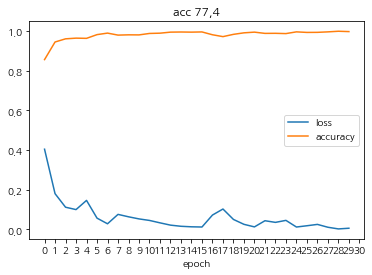

In [31]:
plt.subplots
history=np.array(train_history)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.legend(['loss', 'accuracy'])
plt.xticks(np.arange(0,epochs+1))
plt.xlabel('epoch')
plt.title('acc 77,4')
plt.rcParams['axes.unicode_minus'] = False  
plt.savefig('mobilenet.png')
plt.show()